## Explanations
1. The meticulous preprocessing steps ensure data completeness by handling missing values. The data is split by patient, with each patient’s data being cleaned and aggregated into time windows (6-hour, 8-hour). Missing values in continuous features like ‘Age’ and ‘Dose (10^6 cells/kg)’ are filled using forward-fill and backward-fill techniques, demonstrating our commitment to data integrity. The target variable (the occurrence of Cytokine Release Syndrome (CRS) ) was constructed by identifying whether CRS occurred within the specific prediction window for each time window.  

2. The data split the data into training and test sets ensured temporal separation based on patient-specific data with no data leakage.  

3. SMOTE (Synthetic Minority Over-sampling Technique) was used to balance the training data to address the class imbalance issue where CRS occurrences are much fewer than non-occurrences.

4. Data was prepared into a sequential time series using rolling windows of a specified size (6 hours / 8 hours). Each sequence contains historical data used to predict future CRS occurrences. This transformation is necessary to work with sequential models of LSTM and GRU.  

5. Standard scaling was used to normalize features, ensuring consistent model representation. The scaling prevents certain features from dominating due to different units or scales.
The thorough model training process ensures the reliability of our models.

6. LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit) are both well-suited for sequential data and can capture temporal dependencies, which are important for this problem.Both models were trained using dropout layers for regularization, and class weights were applied to address the imbalance between the CRS and non-CRS classes, demonstrating our commitment to model robustness.

8. The use of early stopping in model training prevents overfitting and ensures that the model generalizes well, instilling confidence in the reliability of our models.

9. The models were evaluated using performance metrics, including accuracy, recall, ROC-AUC, and F1-score. The classification results were further analyzed using confusion matrices and classification report heatmaps.

10. Learning curves for both models are monitored and visualized to assess underfitting/overfitting to learn the required number of epochs for optimal model performance. The models should fit well since training accuracy is consistently slightly higher than validation accuracy.

11. KFold cross-validation, where 80% of the data is used for training and 20% for testing, was used to provide a robust estimate of its performance and reduce the potential for overfitting. The training data is then further processed for oversampling to address class imbalance while the test data remains untouched.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load data
data = pd.read_csv('final_data.csv')
print(data.head())

print("Data shape:", data.shape)
print(data.info())
print("Missing values per column:\n", data.isnull().sum())

date_columns = ['Date of CAR-T infusion', 'datetime', 'Date', 'date', 'Date of last response assesment']
for col in date_columns:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

data = data.sort_values(['patient_id', 'datetime'])

agent_column = 'Agent (JNJ/BMS/Caribou)'

print("Data shape after filtering for agents containing 'JNJ':", data.shape)
print("Unique patient IDs after filtering:", data['patient_id'].unique())

data = data[data[agent_column].str.contains('JNJ', na=False)]
print("Data shape after filtering for JNJ:", data.shape)
print("Unique patient IDs after filtering:", data['patient_id'].unique())


   Unnamed: 0  patient_id    pr_display spo2_display resp_display  \
0           0        7001  71 beats/min          96%          17%   
1           1        7001  71 beats/min          96%          17%   
2           2        7001  71 beats/min          96%          17%   
3           3        7001  71 beats/min          96%          17%   
4           4        7001  71 beats/min          96%          17%   

   pulse_rate_obscount  pulse_rate_avg  pulse_rate_min  pulse_rate_max  \
0                 10.0           70.01           66.63           71.52   
1                 10.0           70.01           66.63           71.52   
2                 10.0           70.01           66.63           71.52   
3                 10.0           70.01           66.63           71.52   
4                 10.0           70.01           66.63           71.52   

   pulse_rate_iqr  ...  QC Deviation from median.1  \
0            2.88  ...                    0.047985   
1            2.88  ...          

In [3]:
# Define baseline features
baseline_features = ['pulse_rate_avg', 'spo2_avg', 'respiratory_rate_avg', 'covered_skin_temperature_avg']

# Compute baseline values before CAR-T infusion
baseline_data = data[data['datetime'] < data['Date of CAR-T infusion']]

baseline = baseline_data.groupby('patient_id')[baseline_features].mean().reset_index()
baseline = baseline.rename(columns={feature: feature + '_baseline' for feature in baseline_features})

# Merge baseline with main data
data = pd.merge(data, baseline, on='patient_id', how='left')
print("Data shape after merging baseline:", data.shape)

# Create delta features
for feature in baseline_features:
    baseline_feature = feature + '_baseline'
    delta_feature = feature + '_delta'
    data[delta_feature] = data[feature] - data[baseline_feature]


Data shape after merging baseline: (171893, 167)


In [4]:
cytokine_columns = ['IL8', 'TNFRSF9', 'TIE2', 'MCP-3', 'CD40-L', 'IL-1 alpha', 'CD244', 'EGF', 'ANGPT1', 'IL7',
                    'PGF', 'IL6', 'ADGRG1', 'MCP-1', 'CRTAM', 'CXCL11', 'MCP-4', 'TRAIL', 'FGF2', 'CXCL9', 'CD8A',
                    'CAIX', 'MUC-16', 'ADA', 'CD4', 'NOS3', 'IL2', 'Gal-9', 'VEGFR-2', 'CD40', 'IL18', 'GZMH',
                    'KIR3DL1', 'LAP TGF-beta-1', 'CXCL1', 'TNFSF14', 'IL33', 'TWEAK', 'PDGF subunit B', 'PDCD1',
                    'FASLG', 'CD28', 'CCL19', 'MCP-2', 'CCL4', 'IL15', 'Gal-1', 'PD-L1', 'CD27', 'CXCL5', 'IL5',
                    'HGF', 'GZMA', 'HO-1', 'CX3CL1', 'CXCL10', 'CD70', 'IL10', 'TNFRSF12A', 'CCL23', 'CD5', 'CCL3',
                    'MMP7', 'ARG1', 'NCR1', 'DCN', 'TNFRSF21', 'TNFRSF4', 'MIC-A/B', 'CCL17', 'ANGPT2', 'PTN',
                    'CXCL12', 'IFN-gamma', 'LAMP3', 'CASP-8', 'ICOSLG', 'MMP12', 'CXCL13', 'PD-L2', 'VEGFA', 'IL4',
                    'LAG3', 'IL12RB1', 'IL13', 'CCL20', 'TNF', 'KLRD1', 'GZMB', 'CD83', 'IL12', 'CSF-1']
cytokine_columns = [col for col in cytokine_columns if col in data.columns]

In [5]:
time_window_size = '6H'
prediction_window_size = pd.Timedelta(hours=6)


crs_occurrences = data[data['CRS on date (0 No, 1 Yes)'] == 1][['patient_id', 'datetime']].drop_duplicates()

aggregated_data_list = []

In [6]:
data

,Unnamed: 0,patient_id,pr_display,spo2_display,resp_display,pulse_rate_obscount,pulse_rate_avg,pulse_rate_min,pulse_rate_max,pulse_rate_iqr,...,HR,Temperature_C,pulse_rate_avg_baseline,spo2_avg_baseline,respiratory_rate_avg_baseline,covered_skin_temperature_avg_baseline,pulse_rate_avg_delta,spo2_avg_delta,respiratory_rate_avg_delta,covered_skin_temperature_avg_delta
0,42646,7004,86 beats/min,81%,11%,1.0,82.37,82.370,82.370,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,42647,7004,86 beats/min,81%,11%,1.0,82.37,82.370,82.370,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,42648,7004,86 beats/min,81%,11%,1.0,82.37,82.370,82.370,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,42649,7004,86 beats/min,81%,11%,1.0,82.37,82.370,82.370,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,42650,7004,86 beats/min,81%,13%,1.0,82.37,82.370,82.370,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171888,319331,7028,63 beats/min,98%,23%,30.0,63.01,59.400,67.370,3.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171889,319332,7028,62 beats/min,98%,23%,17.0,63.52,53.950,70.790,5.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171890,319333,7028,62 beats/min,98%,17-28%,27.0,62.23,60.150,65.230,2.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171891,319334,7028,62 beats/min,98%,17-28%,7.0,60.50,60.370,60.630,0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
aggregated_data_list = []

for patient in data['patient_id'].unique():
    patient_df = data[data['patient_id'] == patient].copy()
    patient_df = patient_df.set_index('datetime')

    # Ensure unique datetime indices
    patient_df = patient_df[~patient_df.index.duplicated(keep='first')]

    numeric_cols = patient_df.select_dtypes(include=[np.number]).columns
    patient_windows = patient_df[numeric_cols].resample(time_window_size).mean()

    # Resample 'Age' and 'Dose' columns
    if 'Age' in patient_df.columns:
        patient_windows['Age'] = patient_df['Age'].resample(time_window_size).ffill()
    if 'Dose (10^6 cells/kg)' in patient_df.columns:
        patient_windows['Dose (10^6 cells/kg)'] = patient_df['Dose (10^6 cells/kg)'].resample(time_window_size).ffill()

    # Add patient_id
    patient_windows['patient_id'] = patient
    patient_windows = patient_windows.reset_index()

    # Assign CRS labels
    patient_windows['CRS'] = 0
    patient_crs_times = crs_occurrences[crs_occurrences['patient_id'] == patient]['datetime']

    for idx in patient_windows.index:
        window_end = patient_windows.loc[idx, 'datetime'] + pd.Timedelta(time_window_size)
        prediction_window_end = window_end + prediction_window_size
        crs_in_window = patient_crs_times[(patient_crs_times >= window_end) & (patient_crs_times < prediction_window_end)]
        if not crs_in_window.empty:
            patient_windows.loc[idx, 'CRS'] = 1

    aggregated_data_list.append(patient_windows)

aggregated_data = pd.concat(aggregated_data_list, ignore_index=True)

# Fill missing values
aggregated_data = aggregated_data.fillna(method='ffill').fillna(method='bfill')

# Feature selection
delta_features = [col for col in aggregated_data.columns if '_delta' in col]
additional_features = ['Age', 'Dose (10^6 cells/kg)'] + cytokine_columns
features = delta_features + [feat for feat in additional_features if feat in aggregated_data.columns]

aggregated_data = aggregated_data.dropna(subset=features + ['CRS'])

X = aggregated_data[features]
y = aggregated_data['CRS']


preprocess data

In [8]:
def preprocess_data(X, y, steps, oversample=False):
    n_samples, n_features = X.shape
    n_sequences = n_samples // steps
    X = X.iloc[:n_sequences * steps].values
    y = y.iloc[:n_sequences * steps].values
    X_reshaped = X.reshape((n_sequences, steps, n_features))
    y_reshaped = y.reshape((n_sequences, steps, 1))
    if oversample:
        oversampler = RandomOverSampler(random_state=42)
        X_flat = X_reshaped.reshape(-1, n_features)
        y_flat = y_reshaped.flatten()
        X_resampled, y_resampled = oversampler.fit_resample(X_flat, y_flat)
        n_resampled_sequences = len(y_resampled) // steps
        X_reshaped = X_resampled[:n_resampled_sequences * steps].reshape((-1, steps, n_features))
        y_reshaped = y_resampled[:n_resampled_sequences * steps].reshape((-1, steps, 1))
    return X_reshaped, y_reshaped


train and evaluate model

In [9]:
def train_and_evaluate_model(X_train_seq, y_train_seq, X_test_seq, y_test_seq, model_type='LSTM'):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
        model.add(Dropout(0.2))
        model.add(LSTM(32, activation='tanh', return_sequences=True))
    elif model_type == 'GRU':
        model.add(GRU(64, activation='tanh', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
        model.add(Dropout(0.2))
        model.add(GRU(32, activation='tanh', return_sequences=True))
    model.add(Dense(1, activation='sigmoid'))  # Sequence output (binary classification for each step)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1)
    y_preds = model.predict(X_test_seq)
    y_preds_class = (y_preds > 0.5).astype(int)
    return model, history, y_preds_class

plot

In [10]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['No CRS', 'CRS'], yticklabels=['No CRS', 'CRS'])
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_learning_curve(history, title):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Learning Curve - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

def plot_classification_report(y_true, y_pred, title):
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).iloc[:-1, :].T
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_report, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Classification Report Heatmap - {title}')
    plt.show()

def plot_metric_comparison(metrics, values, title):
    plt.figure(figsize=(8, 5))
    plt.bar(metrics, values, color='skyblue')
    plt.title(title)
    plt.ylabel('Score')
    plt.grid(axis='y')
    plt.show()

main pipeline with cross validation


Fold 1/5 (Train-Test Split: 80/20)
Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6696 - loss: 0.6256 - val_accuracy: 0.9113 - val_loss: 0.3451
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8999 - loss: 0.3250 - val_accuracy: 0.9698 - val_loss: 0.1773
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9312 - loss: 0.2047 - val_accuracy: 0.9659 - val_loss: 0.2006
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9371 - loss: 0.1847 - val_accuracy: 0.9649 - val_loss: 0.1530
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9443 - loss: 0.1733 - val_accuracy: 0.9639 - val_loss: 0.1752
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9529 - loss: 0.1341 - val_accuracy: 0.9620 - val_loss: 0.1873
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9470 - loss: 0.1506 - val_accuracy: 0.9630 - val_loss: 0.1949
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9445 - loss: 0.

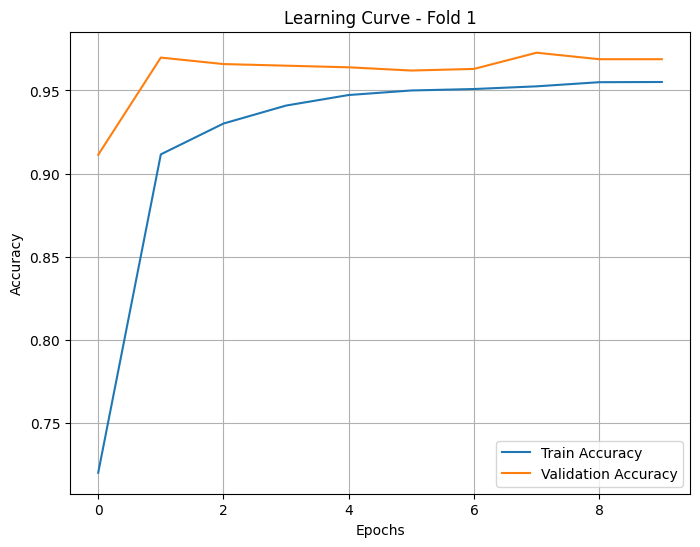

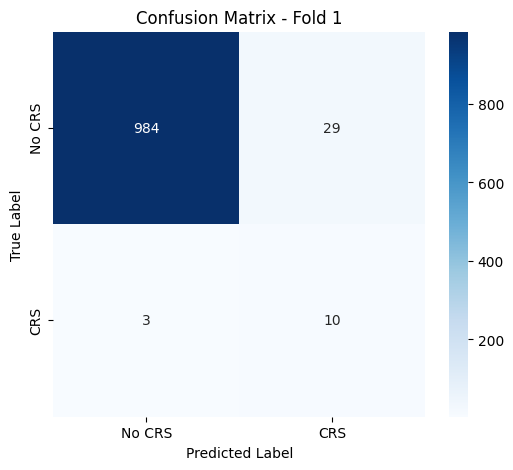

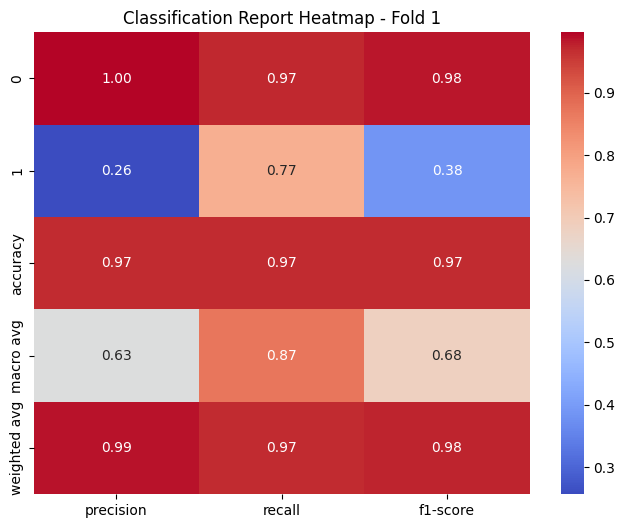


Fold 2/5 (Train-Test Split: 80/20)
Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6789 - loss: 0.6056 - val_accuracy: 0.8957 - val_loss: 0.3381
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9269 - loss: 0.2480 - val_accuracy: 0.8889 - val_loss: 0.3093
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9231 - loss: 0.2098 - val_accuracy: 0.9630 - val_loss: 0.2045
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9378 - loss: 0.1833 - val_accuracy: 0.9561 - val_loss: 0.2080
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9442 - loss: 0.1722 - val_accuracy: 0.9630 - val_loss: 0.1915
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9523 - loss: 0.1411 - val_accuracy: 0.9659 - val_loss: 0.1598
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9513 - loss: 0.1364 - val_accuracy: 0.9669 - val_loss: 0.1571
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9525 - loss:

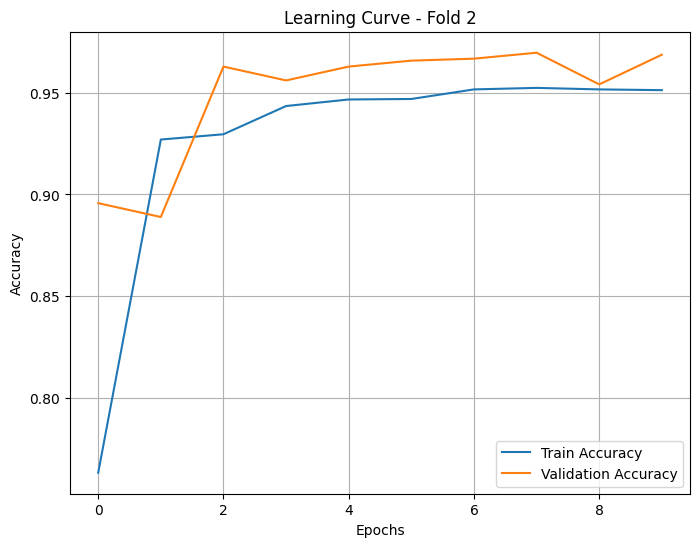

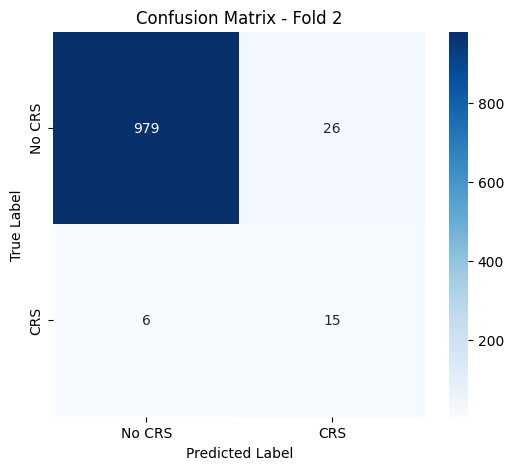

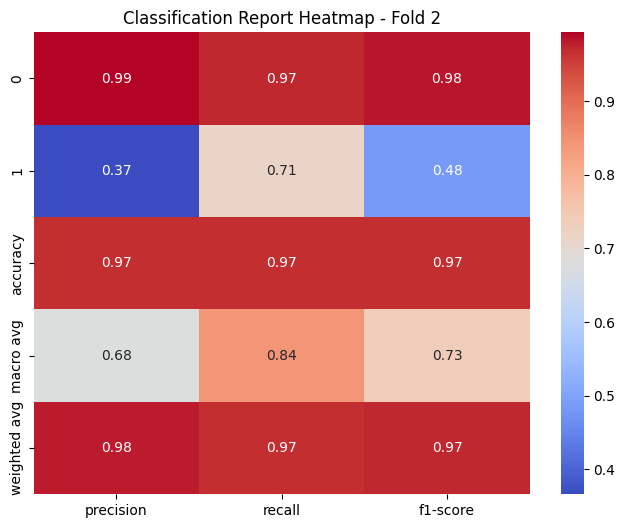


Fold 3/5 (Train-Test Split: 80/20)
Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6881 - loss: 0.6137 - val_accuracy: 0.8626 - val_loss: 0.4051
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8928 - loss: 0.3070 - val_accuracy: 0.8996 - val_loss: 0.2935
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9211 - loss: 0.2023 - val_accuracy: 0.9708 - val_loss: 0.1822
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9350 - loss: 0.1768 - val_accuracy: 0.9717 - val_loss: 0.1711
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9425 - loss: 0.1633 - val_accuracy: 0.9727 - val_loss: 0.1735
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9434 - loss: 0.1447 - val_accuracy: 0.9649 - val_loss: 0.1771
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9484 - loss: 0.1406 - val_accuracy: 0.9678 - val_loss: 0.1482
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9486 - los

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


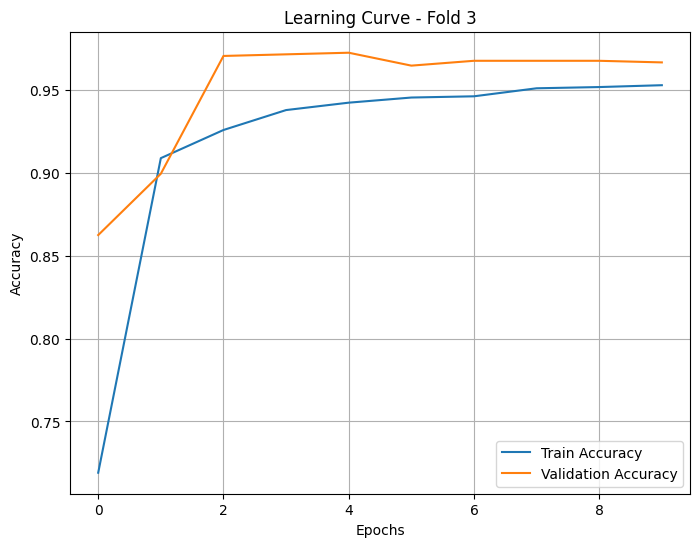

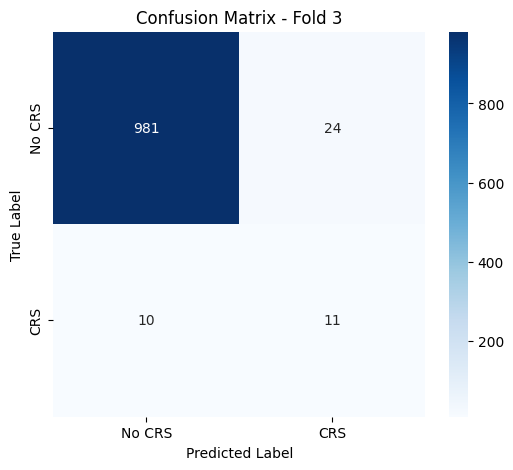

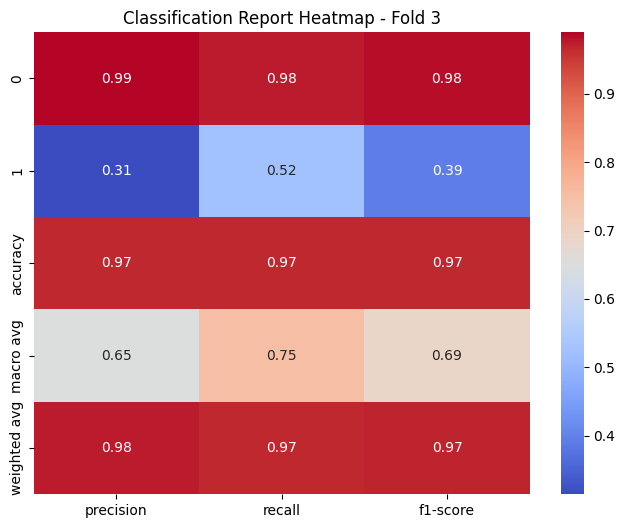


Fold 4/5 (Train-Test Split: 80/20)
Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7259 - loss: 0.5875 - val_accuracy: 0.8548 - val_loss: 0.3493
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9049 - loss: 0.2924 - val_accuracy: 0.9698 - val_loss: 0.1917
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9362 - loss: 0.2021 - val_accuracy: 0.9659 - val_loss: 0.2106
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9457 - loss: 0.1760 - val_accuracy: 0.9669 - val_loss: 0.1728
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9544 - loss: 0.1539 - val_accuracy: 0.9678 - val_loss: 0.1615
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9550 - loss: 0.1425 - val_accuracy: 0.9678 - val_loss: 0.1530
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9578 - loss: 0.1344 - val_accuracy: 0.9669 - val_loss: 0.1371
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9577 - los

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


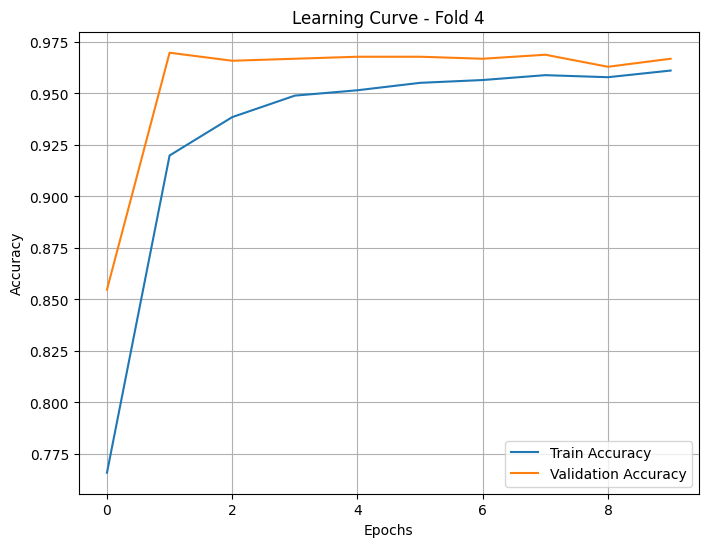

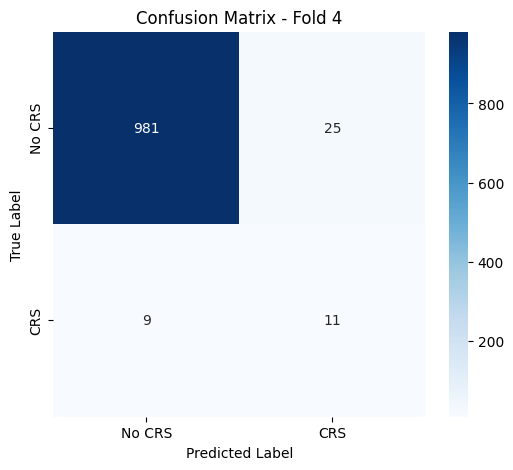

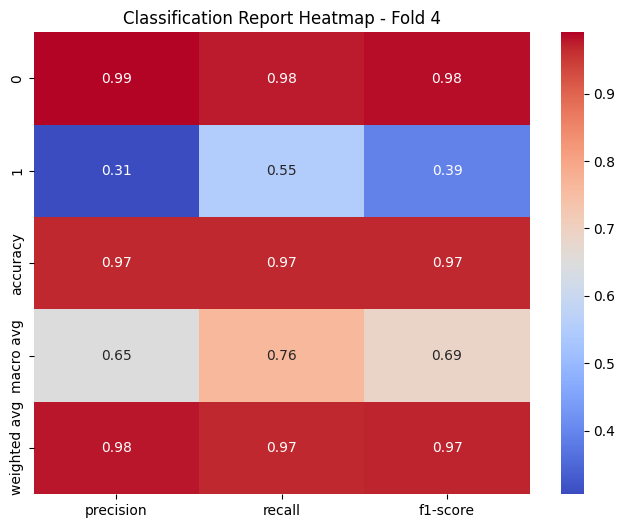


Fold 5/5 (Train-Test Split: 80/20)
Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6570 - loss: 0.6332 - val_accuracy: 0.6491 - val_loss: 0.4649
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8839 - loss: 0.3166 - val_accuracy: 0.9649 - val_loss: 0.2184
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9455 - loss: 0.1838 - val_accuracy: 0.9630 - val_loss: 0.1930
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9455 - loss: 0.1690 - val_accuracy: 0.9708 - val_loss: 0.1516
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9533 - loss: 0.1446 - val_accuracy: 0.9669 - val_loss: 0.2055
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9561 - loss: 0.1389 - val_accuracy: 0.9708 - val_loss: 0.1333
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9509 - loss: 0.1495 - val_accuracy: 0.9639 - val_loss: 0.1761
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9534 - los

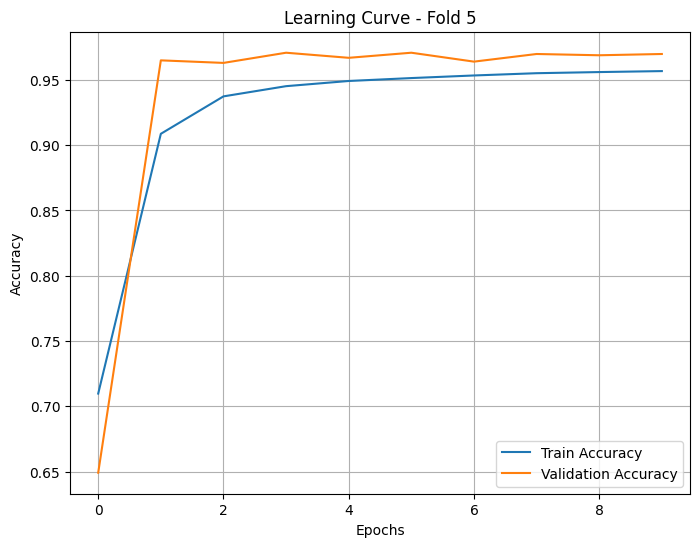

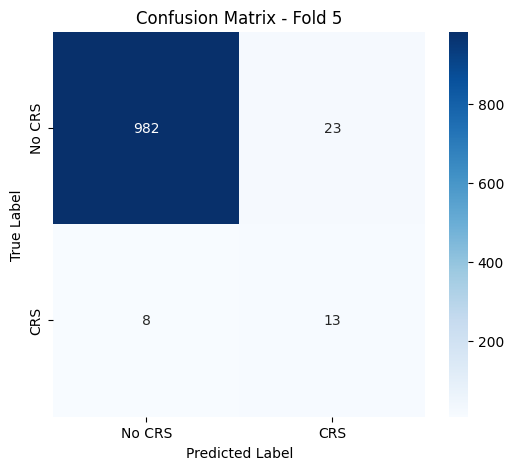

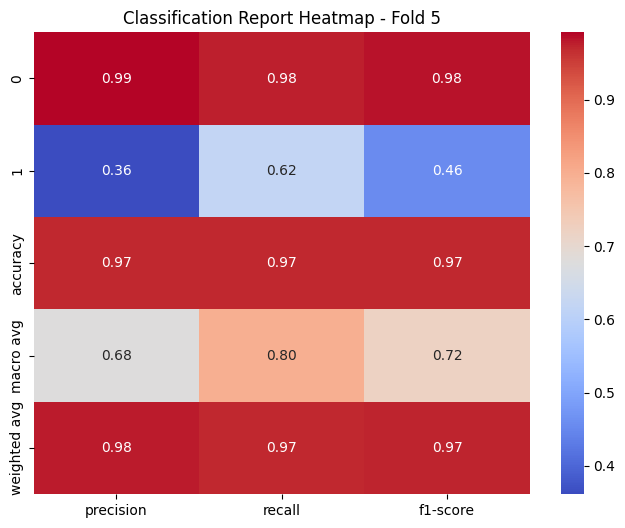


Cross-Validation Results:
Accuracy: Mean 0.97, Std 0.00


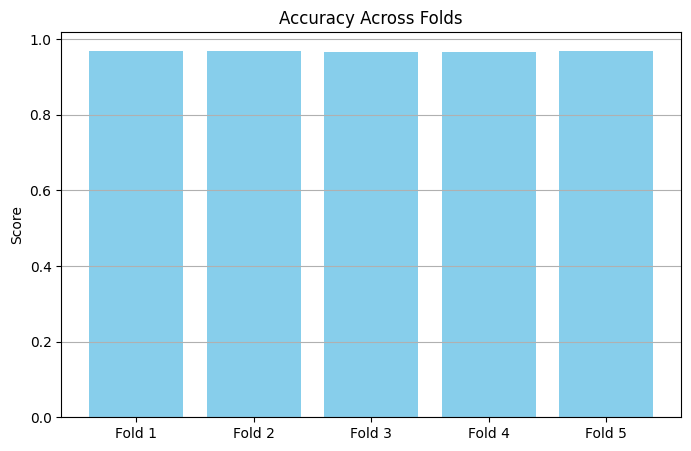

AUC: Mean 0.81, Std 0.05


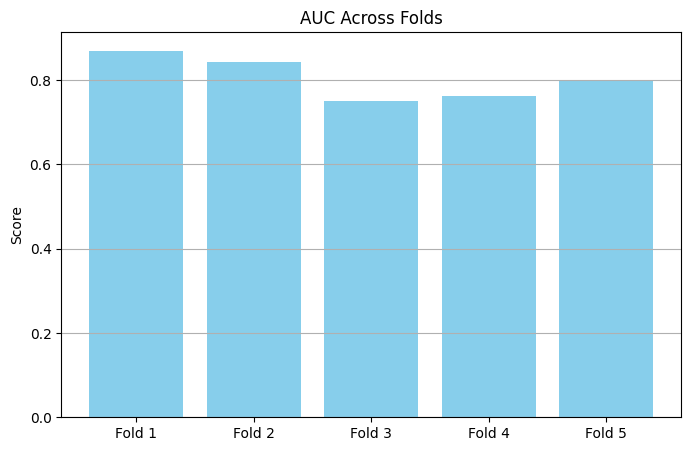

In [11]:
def main_pipeline(data, time_window_size, prediction_window_size, steps=6):
    aggregated_data_list = []
    for patient in data['patient_id'].unique():
        patient_df = data[data['patient_id'] == patient].set_index('datetime')
        patient_df = patient_df[~patient_df.index.duplicated(keep='first')]
        numeric_cols = patient_df.select_dtypes(include=[np.number]).columns
        patient_windows = patient_df[numeric_cols].resample(time_window_size).mean()
        if 'Age' in patient_df.columns:
            patient_windows['Age'] = patient_df['Age'].resample(time_window_size).ffill()
        if 'Dose (10^6 cells/kg)' in patient_df.columns:
            patient_windows['Dose (10^6 cells/kg)'] = patient_df['Dose (10^6 cells/kg)'].resample(time_window_size).ffill()
        patient_windows['patient_id'] = patient
        patient_windows = patient_windows.reset_index()
        patient_windows['CRS'] = 0
        crs_times = crs_occurrences[crs_occurrences['patient_id'] == patient]['datetime']
        for idx in patient_windows.index:
            window_end = patient_windows.loc[idx, 'datetime'] + pd.Timedelta(time_window_size)
            prediction_end = window_end + prediction_window_size
            if not crs_times[(crs_times >= window_end) & (crs_times < prediction_end)].empty:
                patient_windows.loc[idx, 'CRS'] = 1
        aggregated_data_list.append(patient_windows)
    aggregated_data = pd.concat(aggregated_data_list).fillna(method='ffill').fillna(method='bfill')
    delta_features = [col for col in aggregated_data.columns if '_delta' in col]
    additional_features = ['Age', 'Dose (10^6 cells/kg)']
    features = delta_features + [feat for feat in additional_features if feat in aggregated_data.columns]
    aggregated_data = aggregated_data.dropna(subset=features + ['CRS'])
    X = aggregated_data[features]
    y = aggregated_data['CRS']
    # cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_metrics = {'Accuracy': [], 'AUC': []}
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold + 1}/5 (Train-Test Split: 80/20)")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        X_train_seq, y_train_seq = preprocess_data(X_train, y_train, steps, oversample=True)
        X_test_seq, y_test_seq = preprocess_data(X_test, y_test, steps, oversample=False)
        model, history, y_preds_class = train_and_evaluate_model(X_train_seq, y_train_seq, X_test_seq, y_test_seq)
        y_test_flat = y_test_seq.flatten()
        y_preds_flat = y_preds_class.flatten()
        accuracy = accuracy_score(y_test_flat, y_preds_flat)
        auc_score = roc_auc_score(y_test_flat, y_preds_flat)
        cv_metrics['Accuracy'].append(accuracy)
        cv_metrics['AUC'].append(auc_score)
        # visualizations
        plot_learning_curve(history, f"Fold {fold + 1}")
        plot_confusion_matrix(y_test_flat, y_preds_flat, f"Fold {fold + 1}")
        plot_classification_report(y_test_flat, y_preds_flat, f"Fold {fold + 1}")
    print("\nCross-Validation Results:")
    for metric, values in cv_metrics.items():
        print(f"{metric}: Mean {np.mean(values):.2f}, Std {np.std(values):.2f}")
        plot_metric_comparison([f"Fold {i+1}" for i in range(5)], values, f"{metric} Across Folds")
    return cv_metrics
results = main_pipeline(data, time_window_size="6H", prediction_window_size=pd.Timedelta("2H"), steps=6)